### BTC Strategy on Time series momentum - Tobias J. Moskowitz, Yao Hua Ooi, Lasse Heje Pedersen



In [1]:
import subprocess
import sys
import os
from datetime import datetime, timedelta, timezone
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm


import ccxt

pd.options.display.float_format = "{:.6f}".format



In [2]:
def fetch_btc_trades(lookback_hours: int = 24, limit_per_batch: int = 1000) -> pd.DataFrame:
    exchange = ccxt.binance({"enableRateLimit": True})
    symbol = "BTC/USDT"
    end = datetime.now(tz=timezone.utc)
    start = end - timedelta(hours=lookback_hours)
    
    all_trades = []
    since_id = None
    since_ms = int(start.timestamp() * 1000)
    max_ms = int(end.timestamp() * 1000)
    
    print(f"Fetching tick data from Binance...")
    while True:
        try:
            trades = exchange.fetch_trades(symbol, since=since_ms, limit=limit_per_batch, params={"untilId": since_id} if since_id else {})
            if not trades:
                break
            
            for trade in trades:
                ts = trade.get("timestamp")
                if ts and ts <= max_ms:
                    all_trades.append({
                        "timestamp": datetime.fromtimestamp(ts / 1000, tz=timezone.utc),
                        "price": float(trade.get("price", 0)),
                        "amount": float(trade.get("amount", 0)),
                        "side": trade.get("side", "unknown"),
                    })
                    if len(all_trades) >= 50000:
                        break
                if len(all_trades) >= 50000:
                    break
            
            if len(all_trades) >= 50000 or not trades:
                break
            
            since_id = trades[-1].get("id")
            since_ms = trades[-1].get("timestamp")
            
        except Exception as exc:
            print(f"Error fetching trades: {exc}")
            break
    
    df = pd.DataFrame(all_trades).sort_values("timestamp").reset_index(drop=True)
    print(f"Fetched {len(df)} trades")
    return df

In [3]:

def fetch_btc_ohlcv(timeframe: str = "1d", lookback_days: Optional[int] = None, max_days: int = 1000) -> pd.DataFrame:
    exchange = ccxt.binance({"enableRateLimit": True})
    symbol = "BTC/USDT"
    end = datetime.now(tz=timezone.utc)
    
    if lookback_days is not None:
        start = end - timedelta(days=lookback_days)
    else:
        start = datetime(2017, 7, 1, tzinfo=timezone.utc)
    
    since_ms = int(start.timestamp() * 1000)
    limit_per_request = 1000
    
    all_rows = []
    current_since = since_ms
    batch = 0
    
    while len(all_rows) < max_days:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=current_since, limit=limit_per_request)
            
            if not ohlcv or len(ohlcv) == 0:
                break
            
            for ts, op, high, low, close, vol in ohlcv:
                all_rows.append({
                    "timestamp": datetime.fromtimestamp(ts / 1000, tz=timezone.utc),
                    "open": float(op),
                    "high": float(high),
                    "low": float(low),
                    "close": float(close),
                    "volume": float(vol),
                })
            
            batch += 1
            if batch % 10 == 0:
                print(f"Fetched {len(all_rows)} bars so far...")
            
            if len(ohlcv) < limit_per_request:
                break
            
            current_since = ohlcv[-1][0] + 1
            
        except Exception as exc:
            print(f"Fetch error at timestamp {current_since}: {exc}")
            break
    
    df = pd.DataFrame(all_rows)
    df = df.drop_duplicates(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    
    print(f"Fetched {len(df)} bars from {df['timestamp'].min()} to {df['timestamp'].max()}")
    return df



In [4]:
df_btc = fetch_btc_ohlcv(timeframe="1d", lookback_days=None, max_days=5000)
df_btc.set_index("timestamp", inplace=True)
df_btc = df_btc[df_btc.index >= "2017-01-01"]
print(f"\nDonnees BTC recuperees: {len(df_btc)} jours")
print(f"Periode: {df_btc.index.min()} a {df_btc.index.max()}")
print(f"Prix actuel: ${df_btc['close'].iloc[-1]:,.2f}")
print(f"ATH: ${df_btc['close'].max():,.2f}")



Fetched 2996 bars from 2017-08-17 00:00:00+00:00 to 2025-10-29 00:00:00+00:00

Donnees BTC recuperees: 2996 jours
Periode: 2017-08-17 00:00:00+00:00 a 2025-10-29 00:00:00+00:00
Prix actuel: $113,083.34
ATH: $124,658.54


In [5]:
df_btc

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 00:00:00+00:00,4261.480000,4485.390000,4200.740000,4285.080000,795.150377
2017-08-18 00:00:00+00:00,4285.080000,4371.520000,3938.770000,4108.370000,1199.888264
2017-08-19 00:00:00+00:00,4108.370000,4184.690000,3850.000000,4139.980000,381.309763
2017-08-20 00:00:00+00:00,4120.980000,4211.080000,4032.620000,4086.290000,467.083022
2017-08-21 00:00:00+00:00,4069.130000,4119.620000,3911.790000,4016.000000,691.743060
...,...,...,...,...,...
2025-10-25 00:00:00+00:00,111004.900000,111943.190000,110672.860000,111646.270000,6407.968640
2025-10-26 00:00:00+00:00,111646.270000,115466.800000,111260.450000,114559.400000,13454.477370
2025-10-27 00:00:00+00:00,114559.410000,116400.000000,113830.010000,114107.650000,21450.232410


In [6]:
df_flows = pd.DataFrame()
df_flows['flows'] = df_btc['volume'].diff()
df_flows.dropna(inplace=True)
df_flows

,flows
timestamp,
2017-08-18 00:00:00+00:00,404.737887
2017-08-19 00:00:00+00:00,-818.578501
2017-08-20 00:00:00+00:00,85.773259
2017-08-21 00:00:00+00:00,224.660038
2017-08-22 00:00:00+00:00,274.941798
...,...
2025-10-25 00:00:00+00:00,-8597.200490
2025-10-26 00:00:00+00:00,7046.508730
2025-10-27 00:00:00+00:00,7995.755040


In [7]:
fig_flows = go.Figure()
fig_flows.add_trace(go.Bar(x=df_flows.index,y=df_flows['flows'], marker_color=df_flows['flows'].apply(lambda x: 'green' if x >0 else 'red')))
fig_flows.update_layout(
    title="Flows Chart (variation du volume journalier)",
    xaxis_title="Date",
    yaxis_title="Flows (BTC)",
    template="plotly_white"
)
fig_flows.show()

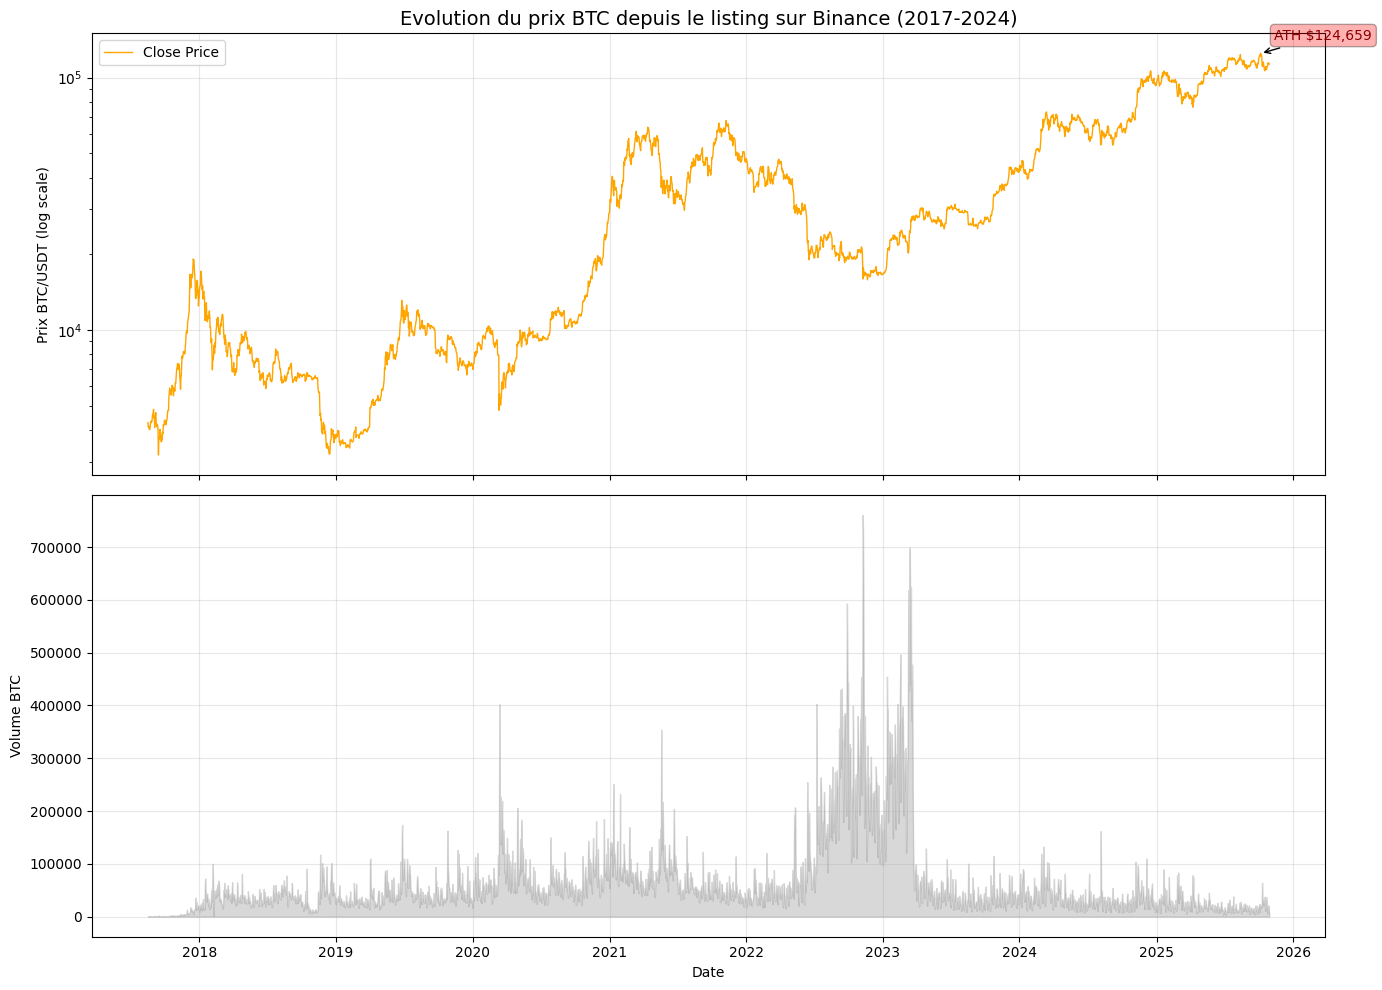

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(df_btc.index, df_btc['close'], linewidth=1, color='orange', label='Close Price')
ax1.set_yscale('log')
ax1.set_ylabel('Prix BTC/USDT (log scale)')
ax1.set_title('Evolution du prix BTC depuis le listing sur Binance (2017-2024)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

ath_date = df_btc['close'].idxmax()
ath_price = df_btc['close'].max()
ax1.annotate(f'ATH ${ath_price:,.0f}', 
             xy=(ath_date, ath_price), 
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
             fontsize=10, color='darkred')

ax2.fill_between(df_btc.index, df_btc['volume'], alpha=0.3, color='gray')
ax2.set_ylabel('Volume BTC')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Time-Series Momentum (TSM) de Pedersen



In [9]:
df_btc

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 00:00:00+00:00,4261.480000,4485.390000,4200.740000,4285.080000,795.150377
2017-08-18 00:00:00+00:00,4285.080000,4371.520000,3938.770000,4108.370000,1199.888264
2017-08-19 00:00:00+00:00,4108.370000,4184.690000,3850.000000,4139.980000,381.309763
2017-08-20 00:00:00+00:00,4120.980000,4211.080000,4032.620000,4086.290000,467.083022
2017-08-21 00:00:00+00:00,4069.130000,4119.620000,3911.790000,4016.000000,691.743060
...,...,...,...,...,...
2025-10-25 00:00:00+00:00,111004.900000,111943.190000,110672.860000,111646.270000,6407.968640
2025-10-26 00:00:00+00:00,111646.270000,115466.800000,111260.450000,114559.400000,13454.477370
2025-10-27 00:00:00+00:00,114559.410000,116400.000000,113830.010000,114107.650000,21450.232410


In [10]:
df_btc
df_btc.dropna(inplace=True)
df_btc

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 00:00:00+00:00,4261.480000,4485.390000,4200.740000,4285.080000,795.150377
2017-08-18 00:00:00+00:00,4285.080000,4371.520000,3938.770000,4108.370000,1199.888264
2017-08-19 00:00:00+00:00,4108.370000,4184.690000,3850.000000,4139.980000,381.309763
2017-08-20 00:00:00+00:00,4120.980000,4211.080000,4032.620000,4086.290000,467.083022
2017-08-21 00:00:00+00:00,4069.130000,4119.620000,3911.790000,4016.000000,691.743060
...,...,...,...,...,...
2025-10-25 00:00:00+00:00,111004.900000,111943.190000,110672.860000,111646.270000,6407.968640
2025-10-26 00:00:00+00:00,111646.270000,115466.800000,111260.450000,114559.400000,13454.477370
2025-10-27 00:00:00+00:00,114559.410000,116400.000000,113830.010000,114107.650000,21450.232410


Exponentially Weighted Moving Average
$$ \sigma_t^2 = (1 - \lambda) r_{t-1}^2 + \lambda \sigma_{t-1}^2 $$

In [11]:
lambda_vol = 0.9836  # EWMA centre-of-mass ≈ 60 jours
vol_floor = 0.15  # plancher de volatilité annualisée pour éviter l'effet levier excessif

returns = df_btc['close'].pct_change().fillna(0.0)

ewma_var = returns.pow(2).ewm(alpha=(1 - lambda_vol), adjust=False).mean()
ewma_sigma_daily = np.sqrt(ewma_var)
ewma_sigma_annual = (ewma_sigma_daily * np.sqrt(252.0)).clip(lower=vol_floor)

df_btc['return'] = returns
df_btc['ewma_vol_daily'] = ewma_sigma_daily
df_btc['ewma_vol_annual'] = ewma_sigma_annual
df_btc.tail()

,open,high,low,close,volume,return,ewma_vol_daily,ewma_vol_annual
timestamp,,,,,,,,
2025-10-25 00:00:00+00:00,111004.900000,111943.190000,110672.860000,111646.270000,6407.968640,0.005778,0.019101,0.303219
2025-10-26 00:00:00+00:00,111646.270000,115466.800000,111260.450000,114559.400000,13454.477370,0.026092,0.019236,0.305364
2025-10-27 00:00:00+00:00,114559.410000,116400.000000,113830.010000,114107.650000,21450.232410,-0.003943,0.019084,0.302956
2025-10-28 00:00:00+00:00,114107.650000,116086.000000,112211.000000,112898.450000,15523.422570,-0.010597,0.018976,0.301233
2025-10-29 00:00:00+00:00,112898.440000,113624.120000,112100.000000,113083.340000,6271.465890,0.001638,0.018821,0.298771


Regression Analysis and trading strat

$$ \frac{r_t}{\sigma_{t-1}} = \alpha + \beta \frac{r_{t-h}}{\sigma_{t-h-1}} + \varepsilon_t $$


In [12]:
sigma = df_btc['ewma_vol_annual']
r = df_btc['return']

r_scaled = r / sigma.shift(1)
lag = 1
r_lagged_scaled = r.shift(lag) / sigma.shift(lag + 1)

$$ y = \alpha + \beta x + \varepsilon $$


In [20]:
def compute_tsm_signals(
    prices: pd.Series,
    lookback_months: int = 12,
    vol_lambda: float = 0.9836,
    target_vol: float = 0.25,
    vol_floor: float = 0.15,
    max_leverage: float = 3.0,
    signal_threshold: float = 0.02,
    transaction_cost_bps: float = 5.0,
    funding: Optional[pd.Series] = None,
) -> pd.DataFrame:
    prices = prices.dropna().sort_index()
    monthly_prices = prices.resample('ME').last()
    daily_returns = prices.pct_change().dropna()

    ewma_var = daily_returns.pow(2).ewm(alpha=1 - vol_lambda, adjust=False).mean()
    ewma_vol_daily = np.sqrt(ewma_var)
    ewma_vol_annual = (ewma_vol_daily * np.sqrt(252.0)).clip(lower=vol_floor)

    df = pd.DataFrame(index=monthly_prices.index)
    df['close'] = monthly_prices
    df['asset_return'] = df['close'].pct_change().fillna(0.0)

    momentum_col = f'momentum_{lookback_months}m'
    df[momentum_col] = df['close'].pct_change(lookback_months)
    df['raw_signal'] = df[momentum_col]
    df['signal_direction'] = np.sign(df['raw_signal'])
    df.loc[df['raw_signal'].abs() < signal_threshold, 'signal_direction'] = 0.0
    df['signal'] = df['signal_direction'].shift(1).fillna(0.0)

    sigma_annual = ewma_vol_annual.resample('ME').last().reindex(df.index)
    sigma_annual = sigma_annual.shift(1)
    sigma_annual = sigma_annual.fillna(method='ffill').fillna(method='bfill')
    sigma_annual = sigma_annual.clip(lower=vol_floor)
    df['sigma_annual'] = sigma_annual

    target_leverage = (target_vol / df['sigma_annual']).replace([np.inf, -np.inf], np.nan)
    df['position_unclipped'] = df['signal'] * target_leverage
    df['position'] = df['position_unclipped'].clip(lower=-max_leverage, upper=max_leverage).fillna(0.0)

    df['turnover'] = df['position'].diff().abs().fillna(df['position'].abs())
    cost_rate = transaction_cost_bps / 10000.0
    df['transaction_cost'] = df['turnover'] * cost_rate

    if funding is not None:
        funding_monthly = funding.resample('ME').sum().reindex(df.index).fillna(0.0)
    else:
        funding_monthly = pd.Series(0.0, index=df.index)

    df['funding_pnl'] = funding_monthly * df['position']
    df['strategy_return_gross'] = df['position'] * df['asset_return']
    df['strategy_return_net'] = df['strategy_return_gross'] - df['transaction_cost'] + df['funding_pnl']
    df['strategy_equity'] = (1.0 + df['strategy_return_net']).cumprod()
    df['buy_hold_equity'] = (1.0 + df['asset_return']).cumprod()

    return df

signals_tsm = compute_tsm_signals(df_btc['close'])
signals_tsm[['close', 'position', 'strategy_return_net']].tail(20)

/tmp/ipykernel_212059/3127126119.py:33: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,close,position,strategy_return_net
timestamp,,,
2024-03-31 00:00:00+00:00,71280.010000,0.600242,0.099629
2024-04-30 00:00:00+00:00,60672.000000,0.496247,-0.073904
2024-05-31 00:00:00+00:00,67540.010000,0.525361,0.059456
2024-06-30 00:00:00+00:00,62772.010000,0.541997,-0.038271
2024-07-31 00:00:00+00:00,64628.000000,0.625757,0.018460
2024-08-31 00:00:00+00:00,58973.990000,0.642360,-0.056205
2024-09-30 00:00:00+00:00,63327.590000,0.545669,0.040234
2024-10-31 00:00:00+00:00,70292.010000,0.599961,0.065953
2024-11-30 00:00:00+00:00,96407.990000,0.653447,0.242752


### Surface momentum (k, h)

Exploration de la signature de continuation : régression des rendements futurs (h mois) sur les rendements passés (k mois) pour k ∈ {3, 6, 9, 12} et h jusqu'à 18 mois.

In [14]:
def compute_momentum_surface(prices: pd.Series, k_values, h_values) -> pd.DataFrame:
    monthly_prices = prices.resample('ME').last().dropna()
    results = []
    for k in k_values:
        past_return = monthly_prices.pct_change(k)
        for h in h_values:
            future_return = monthly_prices.shift(-h) / monthly_prices - 1.0
            df_reg = pd.DataFrame({'past': past_return, 'future': future_return}).dropna()
            if df_reg.empty:
                continue
            X = sm.add_constant(df_reg['past'])
            model = sm.OLS(df_reg['future'], X).fit(cov_type='HAC', cov_kwds={'maxlags': max(1, min(12, h))})
            results.append({
                'k_months': k,
                'h_months': h,
                'beta': model.params['past'],
                't_stat': model.tvalues['past'],
                'n_obs': int(model.nobs),
            })
    return pd.DataFrame(results).sort_values(['k_months', 'h_months'])

k_vals = [3, 6, 9, 12]
h_vals = [1, 3, 6, 9, 12, 15, 18]
momentum_surface_df = compute_momentum_surface(df_btc['close'], k_vals, h_vals)

# Matrices pour lecture rapide (β et t-stat)
beta_matrix = momentum_surface_df.pivot(index='k_months', columns='h_months', values='beta')
tstat_matrix = momentum_surface_df.pivot(index='k_months', columns='h_months', values='t_stat')

momentum_surface_df, beta_matrix, tstat_matrix

(    k_months  h_months      beta    t_stat  n_obs
 0          3         1  0.041981  0.914739     95
 1          3         3  0.016195  0.127864     93
 2          3         6 -0.196577 -1.193216     90
 3          3         9 -0.185219 -1.007187     87
 4          3        12 -0.404667 -1.506209     84
 5          3        15 -0.681558 -1.900113     81
 6          3        18 -0.736571 -1.806711     78
 7          6         1 -0.005918 -0.201995     92
 8          6         3 -0.043511 -0.549255     90
 9          6         6 -0.112691 -1.126239     87
 10         6         9 -0.176739 -1.556665     84
 11         6        12 -0.339965 -1.678461     81
 12         6        15 -0.462699 -2.026543     78
 13         6        18 -0.391938 -1.483539     75
 14         9         1  0.002700  0.108387     89
 15         9         3 -0.016735 -0.264154     87
 16         9         6 -0.107228 -1.623484     84
 17         9         9 -0.200963 -1.802859     81
 18         9        12 -0.3228

### Régressions de validation façon papier

Les rendements normalisés sont régressés sur les signaux retardés pour confirmer la persistance jusqu'à 12 mois.

In [15]:
def tsm_validation_table(signals: pd.DataFrame, horizons, scaled: bool = True, max_hac_lag: int = 6) -> pd.DataFrame:
    df = signals[['asset_return', 'sigma_annual']].dropna()
    y = df['asset_return'] / df['sigma_annual']
    rows = []
    for h in horizons:
        if scaled:
            x_raw = df['asset_return'].shift(h) / df['sigma_annual'].shift(h)
            regressor_label = 'scaled'
        else:
            x_raw = np.sign(df['asset_return'].shift(h))
            regressor_label = 'sign'
        df_reg = pd.DataFrame({'y': y, 'x': x_raw}).dropna()
        if df_reg.empty:
            continue
        hac_lag = max(1, min(max_hac_lag, h))
        X = sm.add_constant(df_reg['x'])
        model = sm.OLS(df_reg['y'], X).fit(cov_type='HAC', cov_kwds={'maxlags': hac_lag})
        rows.append({
            'h_months': h,
            'beta': model.params['x'],
            't_stat': model.tvalues['x'],
            'n_obs': int(model.nobs),
            'regressor': regressor_label,
        })
    return pd.DataFrame(rows).sort_values(['regressor', 'h_months'])

horizons = list(range(1, 19))
validation_scaled = tsm_validation_table(signals_tsm, horizons, scaled=True)
validation_sign = tsm_validation_table(signals_tsm, horizons, scaled=False)
validation_scaled, validation_sign

(    h_months      beta    t_stat  n_obs regressor
 0          1  0.223616  2.474385     98    scaled
 1          2  0.029810  0.357494     97    scaled
 2          3  0.003155  0.037128     96    scaled
 3          4 -0.022057 -0.258478     95    scaled
 4          5 -0.096795 -1.034652     94    scaled
 5          6 -0.129215 -1.059974     93    scaled
 6          7 -0.126556 -1.803676     92    scaled
 7          8  0.095943  1.263442     91    scaled
 8          9  0.004306  0.041964     90    scaled
 9         10 -0.072670 -1.100387     89    scaled
 10        11  0.024825  0.327720     88    scaled
 11        12 -0.108813 -1.216650     87    scaled
 12        13 -0.058256 -0.508273     86    scaled
 13        14 -0.072439 -0.939578     85    scaled
 14        15 -0.075816 -0.733944     84    scaled
 15        16 -0.142172 -1.694721     83    scaled
 16        17 -0.015442 -0.149214     82    scaled
 17        18  0.112611  0.614786     81    scaled,
     h_months      beta    t_s

### Convexité (profil straddle-like)

Régression des rendements de la stratégie sur le BTC et son carré pour mesurer la convexité (β₂).

In [16]:
def convexity_regression(signals: pd.DataFrame):
    df = signals[['strategy_return_net', 'asset_return']].dropna().copy()
    df['squared_return'] = df['asset_return'] ** 2
    X = sm.add_constant(df[['asset_return', 'squared_return']])
    model = sm.OLS(df['strategy_return_net'], X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    return model

convexity_model = convexity_regression(signals_tsm)
pd.Series({
    'alpha': convexity_model.params['const'],
    'beta_1': convexity_model.params['asset_return'],
    'beta_2': convexity_model.params['squared_return'],
    't_alpha': convexity_model.tvalues['const'],
    't_beta_1': convexity_model.tvalues['asset_return'],
    't_beta_2': convexity_model.tvalues['squared_return'],
    'r_squared': convexity_model.rsquared,
    'n_obs': int(convexity_model.nobs),
})

alpha        0.011310
beta_1       0.145593
beta_2      -0.131341
t_alpha      1.404225
t_beta_1     1.446536
t_beta_2    -0.395291
r_squared    0.074660
n_obs       99.000000
dtype: float64

In [17]:
def compute_metrics(prices: pd.Series, rsi_window: int = 14) -> pd.DataFrame:
    close = prices.dropna().copy()
    returns = close.pct_change().dropna()
    vol = returns.rolling(30).std() * np.sqrt(365)
    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = -delta.clip(upper=0.0)
    roll_up = gain.ewm(alpha=1 / rsi_window, adjust=False).mean()
    roll_down = loss.ewm(alpha=1 / rsi_window, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-9)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    out = pd.DataFrame({
        "close": close,
        "return": returns,
        "vol_30d": vol,
        f"rsi_{rsi_window}": rsi,
    })
    return out

metrics = compute_metrics(df_btc["close"]) 
metrics.tail()


,close,return,vol_30d,rsi_14
timestamp,,,,
2025-10-25 00:00:00+00:00,111646.270000,0.005778,0.430046,48.376751
2025-10-26 00:00:00+00:00,114559.400000,0.026092,0.438588,54.130621
2025-10-27 00:00:00+00:00,114107.650000,-0.003943,0.438995,53.141450
2025-10-28 00:00:00+00:00,112898.450000,-0.010597,0.433949,50.482248
2025-10-29 00:00:00+00:00,113083.340000,0.001638,0.428729,50.886931


In [18]:
def performance_summary(returns: pd.Series, periods_per_year: int = 12) -> pd.Series:
    series = returns.dropna()
    if series.empty:
        return pd.Series(dtype=float)
    cumulative = (1.0 + series).cumprod()
    annual_return = cumulative.iloc[-1] ** (periods_per_year / len(series)) - 1.0
    annual_vol = series.std() * np.sqrt(periods_per_year)
    sharpe = annual_return / annual_vol if annual_vol > 0 else np.nan
    drawdown = cumulative / cumulative.cummax() - 1.0
    max_drawdown = drawdown.min()
    return pd.Series({
        "annual_return": annual_return,
        "annual_vol": annual_vol,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    })

performance_df = pd.DataFrame({
    "TSM": performance_summary(signals_tsm["strategy_return_net"]),
    "BuyHold": performance_summary(signals_tsm["asset_return"]),
})
performance_df

,TSM,BuyHold
annual_return,0.108037,0.469442
annual_vol,0.327610,0.716367
sharpe,0.329774,0.655309
max_drawdown,-0.544541,-0.749635


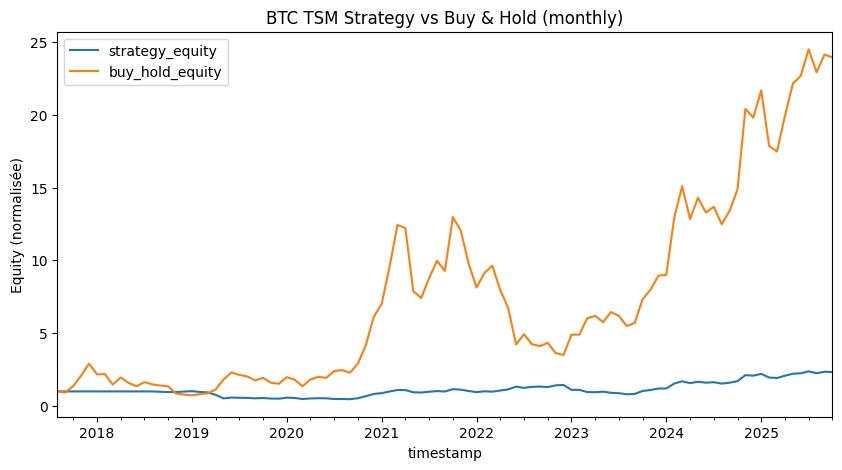

In [19]:
ax = signals_tsm[["strategy_equity", "buy_hold_equity"]].plot(
    figsize=(10, 5),
    title="BTC TSM Strategy vs Buy & Hold (monthly)"
)
ax.set_ylabel("Equity (normalisée)")
plt.show()